# PHƯƠNG ÁN A: TỐI ƯU MÔ HÌNH VỚI 5 FEATURES

**Mục tiêu:** Dự đoán `tải tiêu thụ` từ 5 features (loại bỏ `sản lượng` do correlation = 1.0 với `công suất tb`)

**Features:** độ ẩm, nhiệt độ, góc nghiêng, ca, công suất tb

**Pipeline:**
1. EDA & Phân tích tương quan
2. Tiền xử lý (StandardScaler)
3. Train & Evaluate 16+ mô hình (MLP, RF, GB, XGBoost, LightGBM, SVR)
4. K-Fold Cross Validation
5. Stacking Ensemble
6. Xuất kết quả Excel + Biểu đồ

## 0. CÀI ĐẶT THƯ VIỆN

In [1]:
!pip install numpy pandas scikit-learn openpyxl matplotlib seaborn xgboost lightgbm -q

## 1. IMPORT & CẤU HÌNH

In [2]:
import os, time, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import clone
from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
)
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 10

RANDOM_STATE = 42
N_FOLDS = 5
TEST_SIZE = 0.2
np.random.seed(RANDOM_STATE)

print("Libraries loaded OK!")

Libraries loaded OK!


## 2. ĐỌC DỮ LIỆU

In [3]:
df = pd.read_excel('data3.xlsx')
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
df.head(10)

Shape: (5220, 7)
Columns: ['độ ẩm', 'nhiệt độ', 'góc nghiêng', 'ca', 'công suất tb', 'sản lượng', 'tải tiêu thụ']


,độ ẩm,nhiệt độ,góc nghiêng,ca,công suất tb,sản lượng,tải tiêu thụ
0,97,29,20,1,302.0,2416.0,12080
1,95,28,20,1,290.0,2320.0,11600
2,92,27,20,1,293.0,2344.0,11720
3,92,27,20,1,286.0,2288.0,11440
4,90,27,20,1,289.0,2312.0,11560
5,91,29,20,1,308.0,2464.0,12320
6,97,28,20,1,306.0,2448.0,12240
7,96,27,20,1,308.0,2464.0,12320
8,91,29,20,1,299.0,2392.0,11960
9,97,27,20,1,291.0,2328.0,11640


In [4]:
df.describe()

,độ ẩm,nhiệt độ,góc nghiêng,ca,công suất tb,sản lượng,tải tiêu thụ
count,5220.000000,5220.000000,5220.000000,5220.000000,5220.000000,5220.000000,5220.000000
mean,93.555939,28.530843,21.333333,2.003831,265.423448,2123.387586,10616.937931
std,2.338669,1.137259,0.942899,1.000088,30.600339,244.802712,1224.013561
min,90.000000,27.000000,20.000000,1.000000,224.000000,1792.000000,8960.000000
25%,91.000000,27.000000,20.000000,1.000000,236.000000,1888.000000,9440.000000
50%,94.000000,29.000000,22.000000,3.000000,248.000000,1984.000000,9920.000000
75%,96.000000,30.000000,22.000000,3.000000,295.000000,2360.000000,11800.000000
max,97.000000,30.000000,22.000000,3.000000,310.000000,2480.000000,12400.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5220 entries, 0 to 5219
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   độ ẩm         5220 non-null   int64  
 1   nhiệt độ      5220 non-null   int64  
 2   góc nghiêng   5220 non-null   int64  
 3   ca            5220 non-null   int64  
 4   công suất tb  5220 non-null   float64
 5   sản lượng     5220 non-null   float64
 6   tải tiêu thụ  5220 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 285.6 KB


## 3. EDA - PHÂN TÍCH KHÁM PHÁ

### 3.1 Ma trận tương quan Pearson

In [6]:
corr_matrix = df.corr()
print("=" * 50)
print("MA TRẬN TƯƠNG QUAN PEARSON")
print("=" * 50)
display(corr_matrix.round(4))

# Tương quan với target
target_col = df.columns[-1]
print(f"\nTương quan với '{target_col}':")
print("-" * 40)
corr_with_target = corr_matrix[target_col].drop(target_col).sort_values(key=abs, ascending=False)
for feat, corr in corr_with_target.items():
    print(f"  {feat:<20} : {corr:>8.4f}")

MA TRẬN TƯƠNG QUAN PEARSON


,độ ẩm,nhiệt độ,góc nghiêng,ca,công suất tb,sản lượng,tải tiêu thụ
độ ẩm,1.0000,-0.0109,0.0127,-0.0003,0.0016,0.0016,0.0016
nhiệt độ,-0.0109,1.0000,-0.0169,-0.0009,0.0012,0.0012,0.0012
góc nghiêng,0.0127,-0.0169,1.0000,-0.0054,0.0042,0.0042,0.0042
ca,-0.0003,-0.0009,-0.0054,1.0000,-0.9643,-0.9643,-0.9643
công suất tb,0.0016,0.0012,0.0042,-0.9643,1.0000,1.0000,1.0000
sản lượng,0.0016,0.0012,0.0042,-0.9643,1.0000,1.0000,1.0000
tải tiêu thụ,0.0016,0.0012,0.0042,-0.9643,1.0000,1.0000,1.0000



Tương quan với 'tải tiêu thụ':
----------------------------------------
  công suất tb         :   1.0000
  sản lượng            :   1.0000
  ca                   :  -0.9643
  góc nghiêng          :   0.0042
  độ ẩm                :   0.0016
  nhiệt độ             :   0.0012


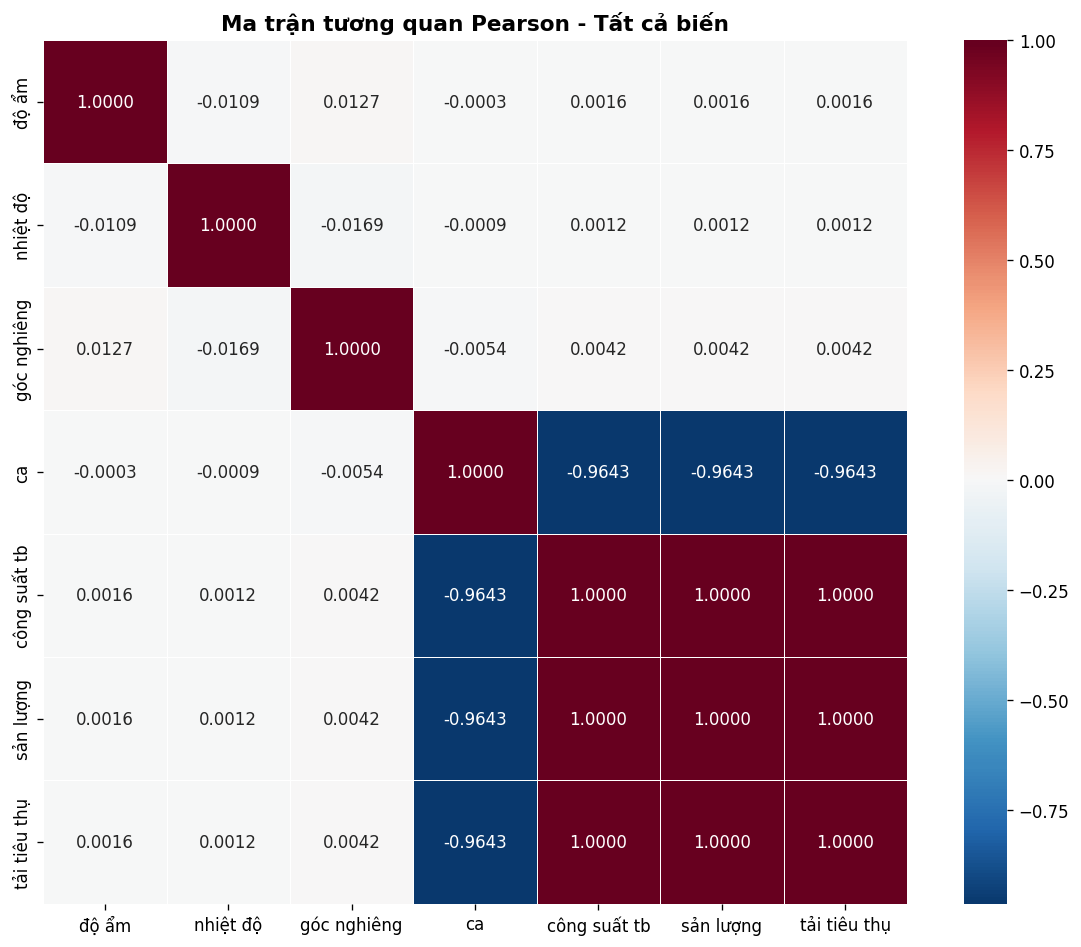


⚠️  CHÚ Ý: 'sản lượng' có corr = 1.000 với 'công suất tb' → LOẠI BỎ (dư thừa hoàn toàn)


In [7]:
# Heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.4f', cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, ax=ax)
ax.set_title('Ma trận tương quan Pearson - Tất cả biến', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('01_correlation_heatmap_full.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n⚠️  CHÚ Ý: 'sản lượng' có corr = 1.000 với 'công suất tb' → LOẠI BỎ (dư thừa hoàn toàn)")

### 3.2 Xác minh quan hệ tuyến tính giữa 3 biến

In [8]:
cols = list(df.columns)
print("Kiểm tra quan hệ tuyến tính:")
print(f"  sản lượng / công suất tb  = {(df[cols[5]] / df[cols[4]]).unique()}")
print(f"  tải tiêu thụ / sản lượng  = {(df[cols[6]] / df[cols[5]]).unique()[:5]}...")
print(f"  tải tiêu thụ / công suất tb = {(df[cols[6]] / df[cols[4]]).unique()[:5]}...")
print()
print("→ sản lượng = công suất tb × 8 (chính xác)")
print("→ tải tiêu thụ ≈ công suất tb × 40 (gần chính xác)")
print("→ 3 biến này thực chất là CÙNG MỘT BIẾN, chỉ khác hệ số")
print("\n⇒ PHƯƠNG ÁN A: Loại bỏ 'sản lượng', giữ 'công suất tb' + 4 biến môi trường")

Kiểm tra quan hệ tuyến tính:
  sản lượng / công suất tb  = [8.]
  tải tiêu thụ / sản lượng  = [5. 5.]...
  tải tiêu thụ / công suất tb = [40. 40.]...

→ sản lượng = công suất tb × 8 (chính xác)
→ tải tiêu thụ ≈ công suất tb × 40 (gần chính xác)
→ 3 biến này thực chất là CÙNG MỘT BIẾN, chỉ khác hệ số

⇒ PHƯƠNG ÁN A: Loại bỏ 'sản lượng', giữ 'công suất tb' + 4 biến môi trường


### 3.3 Phân phối các biến

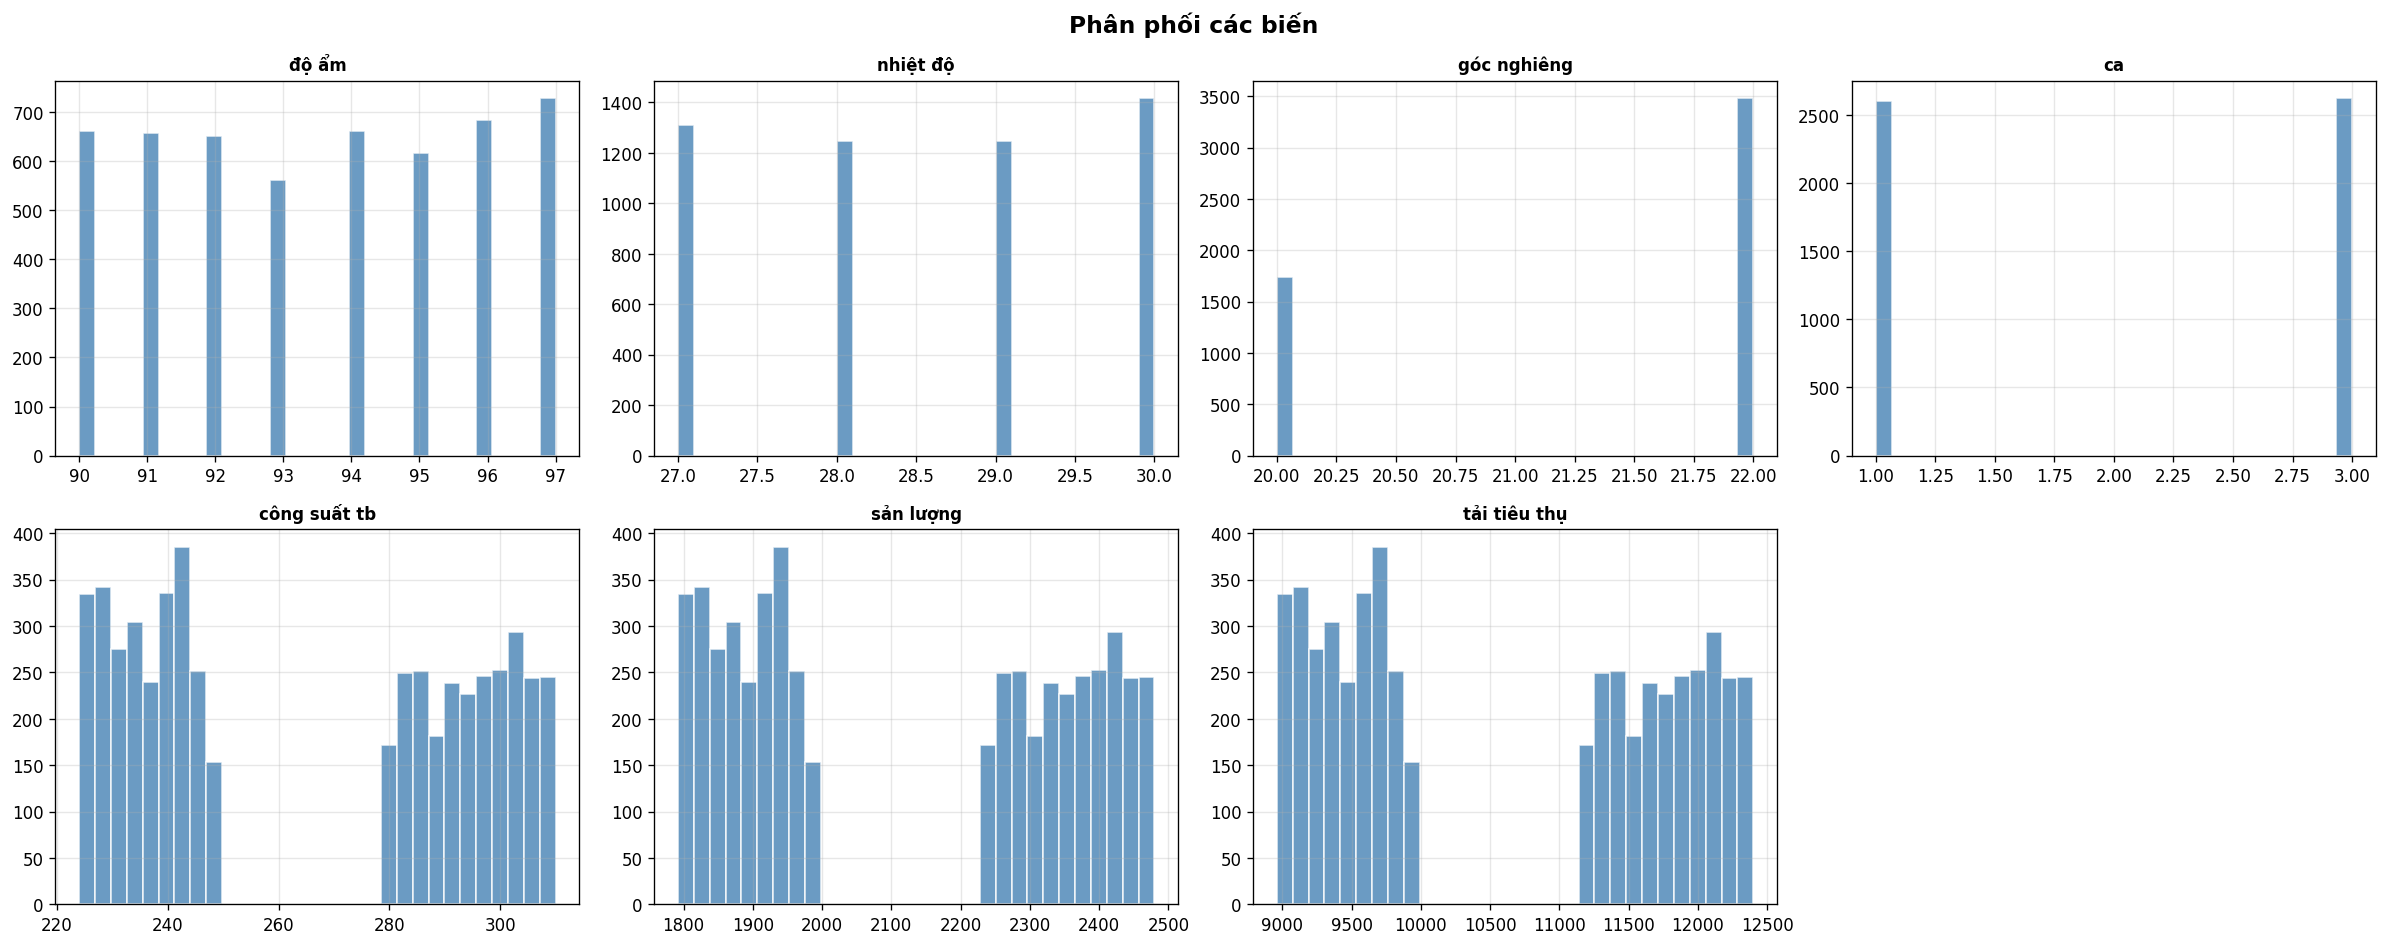

In [9]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
axes = axes.flatten()
for i, col in enumerate(df.columns):
    df[col].hist(bins=30, ax=axes[i], color='steelblue', edgecolor='white', alpha=0.8)
    axes[i].set_title(col, fontweight='bold', fontsize=10)
    axes[i].grid(True, alpha=0.3)
if len(df.columns) < len(axes):
    axes[-1].set_visible(False)
plt.suptitle('Phân phối các biến', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('02_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. CHUẨN BỊ DỮ LIỆU - PHƯƠNG ÁN A (5 FEATURES)

In [10]:
cols = list(df.columns)
target_col = cols[-1]  # tải tiêu thụ

# Phương Án A: 5 features (loại bỏ 'sản lượng')
features_A = [cols[0], cols[1], cols[2], cols[3], cols[4]]
# = ['độ ẩm', 'nhiệt độ', 'góc nghiêng', 'ca', 'công suất tb']

X = df[features_A].values
y = df[target_col].values

print(f"Features ({len(features_A)}): {features_A}")
print(f"Target: {target_col}")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"y range: [{y.min():.0f}, {y.max():.0f}], mean={y.mean():.2f}, std={y.std():.2f}")

Features (5): ['độ ẩm', 'nhiệt độ', 'góc nghiêng', 'ca', 'công suất tb']
Target: tải tiêu thụ
X shape: (5220, 5)
y shape: (5220,)
y range: [8960, 12400], mean=10616.94, std=1223.90


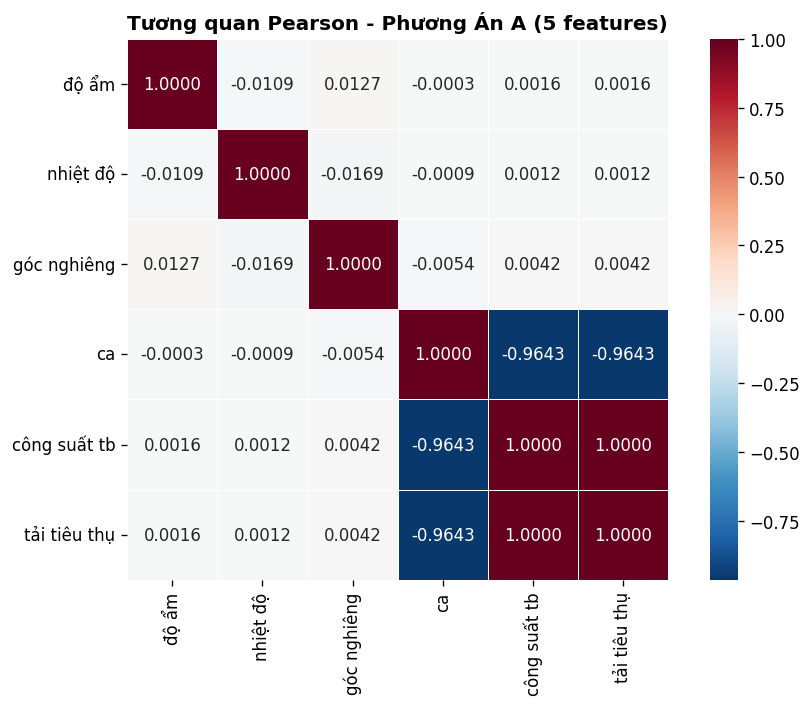

In [11]:
# Heatmap chỉ cho 5 features + target (sau khi loại sản lượng)
df_A = df[features_A + [target_col]]
corr_A = df_A.corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_A, annot=True, fmt='.4f', cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, ax=ax)
ax.set_title('Tương quan Pearson - Phương Án A (5 features)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('03_correlation_planA.png', dpi=150, bbox_inches='tight')
plt.show()

In [12]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# StandardScaler
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)
X_all_sc = scaler.transform(X)

print(f"Train: {X_train_sc.shape[0]} samples")
print(f"Test:  {X_test_sc.shape[0]} samples")
print(f"StandardScaler applied ✓")

Train: 4176 samples
Test:  1044 samples
StandardScaler applied ✓


## 5. ĐỊNH NGHĨA CÁC MÔ HÌNH

In [13]:
models = {}

# ---- MLP Variants ----
models['MLP_(4)'] = MLPRegressor(
    hidden_layer_sizes=(4,), activation='relu', solver='adam',
    max_iter=2000, early_stopping=True, validation_fraction=0.1,
    random_state=RANDOM_STATE)

models['MLP_(8)'] = MLPRegressor(
    hidden_layer_sizes=(8,), activation='relu', solver='adam',
    alpha=0.001, learning_rate='adaptive',
    max_iter=2000, early_stopping=True, validation_fraction=0.1,
    n_iter_no_change=20, random_state=RANDOM_STATE)

models['MLP_(16)'] = MLPRegressor(
    hidden_layer_sizes=(16,), activation='relu', solver='adam',
    alpha=0.001, learning_rate='adaptive',
    max_iter=2000, early_stopping=True, validation_fraction=0.1,
    n_iter_no_change=20, random_state=RANDOM_STATE)

models['MLP_(16,8)'] = MLPRegressor(
    hidden_layer_sizes=(16, 8), activation='relu', solver='adam',
    alpha=0.001, learning_rate='adaptive',
    max_iter=2000, early_stopping=True, validation_fraction=0.1,
    n_iter_no_change=20, random_state=RANDOM_STATE)

models['MLP_(32,16)'] = MLPRegressor(
    hidden_layer_sizes=(32, 16), activation='relu', solver='adam',
    alpha=0.001, learning_rate='adaptive',
    max_iter=2000, early_stopping=True, validation_fraction=0.1,
    n_iter_no_change=20, random_state=RANDOM_STATE)

models['MLP_(32,16,8)'] = MLPRegressor(
    hidden_layer_sizes=(32, 16, 8), activation='relu', solver='adam',
    alpha=0.001, learning_rate='adaptive',
    max_iter=2000, early_stopping=True, validation_fraction=0.1,
    n_iter_no_change=20, random_state=RANDOM_STATE)

models['MLP_tanh_(16,8)'] = MLPRegressor(
    hidden_layer_sizes=(16, 8), activation='tanh', solver='adam',
    alpha=0.0001, learning_rate='adaptive',
    max_iter=2000, early_stopping=True, validation_fraction=0.1,
    n_iter_no_change=20, random_state=RANDOM_STATE)

models['MLP_logistic_(16,8)'] = MLPRegressor(
    hidden_layer_sizes=(16, 8), activation='logistic', solver='adam',
    alpha=0.0001, learning_rate='adaptive',
    max_iter=2000, early_stopping=True, validation_fraction=0.1,
    n_iter_no_change=20, random_state=RANDOM_STATE)

models['MLP_lbfgs_(16,8)'] = MLPRegressor(
    hidden_layer_sizes=(16, 8), activation='relu', solver='lbfgs',
    alpha=0.001, max_iter=500, random_state=RANDOM_STATE)

# ---- Random Forest ----
models['RF_300'] = RandomForestRegressor(
    n_estimators=300, max_depth=None, min_samples_split=5,
    min_samples_leaf=2, random_state=RANDOM_STATE, n_jobs=-1)

models['RF_500'] = RandomForestRegressor(
    n_estimators=500, max_depth=20, min_samples_split=3,
    min_samples_leaf=1, random_state=RANDOM_STATE, n_jobs=-1)

# ---- Gradient Boosting ----
models['GB_300'] = GradientBoostingRegressor(
    n_estimators=300, max_depth=5, learning_rate=0.1,
    subsample=0.8, random_state=RANDOM_STATE)

models['GB_500'] = GradientBoostingRegressor(
    n_estimators=500, max_depth=6, learning_rate=0.05,
    subsample=0.9, min_samples_split=5, random_state=RANDOM_STATE)

# ---- XGBoost ----
models['XGB_300'] = XGBRegressor(
    n_estimators=300, max_depth=6, learning_rate=0.1,
    subsample=0.8, colsample_bytree=0.8,
    reg_alpha=0.1, reg_lambda=1.0,
    random_state=RANDOM_STATE, verbosity=0, n_jobs=-1)

models['XGB_tuned'] = XGBRegressor(
    n_estimators=500, max_depth=8, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.9,
    reg_alpha=0.01, reg_lambda=0.5, min_child_weight=3,
    random_state=RANDOM_STATE, verbosity=0, n_jobs=-1)

# ---- LightGBM ----
models['LGBM_300'] = LGBMRegressor(
    n_estimators=300, max_depth=6, learning_rate=0.1,
    subsample=0.8, colsample_bytree=0.8,
    reg_alpha=0.1, reg_lambda=1.0,
    random_state=RANDOM_STATE, verbosity=-1, n_jobs=-1)

models['LGBM_tuned'] = LGBMRegressor(
    n_estimators=500, max_depth=-1, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.9, num_leaves=50,
    reg_alpha=0.01, reg_lambda=0.5,
    random_state=RANDOM_STATE, verbosity=-1, n_jobs=-1)

# ---- SVR ----
models['SVR_rbf'] = SVR(kernel='rbf', C=100, epsilon=0.1, gamma='scale')
models['SVR_poly'] = SVR(kernel='poly', C=100, epsilon=0.1, degree=3)

print(f"Tổng cộng {len(models)} mô hình được định nghĩa:")
for i, name in enumerate(models, 1):
    print(f"  {i:2d}. {name}")

Tổng cộng 19 mô hình được định nghĩa:
   1. MLP_(4)
   2. MLP_(8)
   3. MLP_(16)
   4. MLP_(16,8)
   5. MLP_(32,16)
   6. MLP_(32,16,8)
   7. MLP_tanh_(16,8)
   8. MLP_logistic_(16,8)
   9. MLP_lbfgs_(16,8)
  10. RF_300
  11. RF_500
  12. GB_300
  13. GB_500
  14. XGB_300
  15. XGB_tuned
  16. LGBM_300
  17. LGBM_tuned
  18. SVR_rbf
  19. SVR_poly


## 6. HÀM TIỆN ÍCH

In [14]:
def calc_metrics(y_true, y_pred):
    """Tính tất cả metrics đánh giá"""
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    nrmse = rmse / (y_true.max() - y_true.min()) if (y_true.max() - y_true.min()) > 0 else 0
    return {
        'MAE': round(mae, 4),
        'MSE': round(mse, 4),
        'RMSE': round(rmse, 4),
        'MAPE (%)': round(mape, 6),
        'nRMSE': round(nrmse, 6),
        'R2': round(r2, 6),
    }


def run_kfold(model, X, y, n_folds=N_FOLDS):
    """K-Fold Cross Validation"""
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_STATE)
    fold_metrics = []
    for train_idx, val_idx in kfold.split(X):
        m = clone(model)
        m.fit(X[train_idx], y[train_idx])
        y_pred = m.predict(X[val_idx])
        fold_metrics.append(calc_metrics(y[val_idx], y_pred))
    result = {}
    for key in fold_metrics[0]:
        values = [fm[key] for fm in fold_metrics]
        result[f'{key}_mean'] = round(np.mean(values), 6)
        result[f'{key}_std'] = round(np.std(values), 6)
    return result

print("Utility functions defined ✓")

Utility functions defined ✓


## 7. TRAIN & EVALUATE TẤT CẢ MÔ HÌNH

In [15]:
all_results = []
predictions = {}

total_start = time.time()
print(f"Bắt đầu train {len(models)} mô hình...")
print("=" * 80)

for i, (name, model) in enumerate(models.items(), 1):
    print(f"\n[{i}/{len(models)}] {name}...", end=" ")

    t0 = time.time()
    try:
        # Train
        m = clone(model)
        m.fit(X_train_sc, y_train)
        train_time = round(time.time() - t0, 3)

        # Predict
        y_pred_train = m.predict(X_train_sc)
        y_pred_test = m.predict(X_test_sc)

        # Metrics
        test_metrics = calc_metrics(y_test, y_pred_test)
        train_metrics = calc_metrics(y_train, y_pred_train)

        # K-Fold CV
        cv = run_kfold(clone(model), X_all_sc, y)

        row = {
            'Mo hinh': name,
            'MAE (Test)': test_metrics['MAE'],
            'RMSE (Test)': test_metrics['RMSE'],
            'MAPE % (Test)': test_metrics['MAPE (%)'],
            'nRMSE (Test)': test_metrics['nRMSE'],
            'R2 (Test)': test_metrics['R2'],
            'MAE (Train)': train_metrics['MAE'],
            'MAPE % (Train)': train_metrics['MAPE (%)'],
            'MAE_CV_mean': cv['MAE_mean'],
            'MAE_CV_std': cv['MAE_std'],
            'MAPE_CV_mean': cv['MAPE (%)_mean'],
            'MAPE_CV_std': cv['MAPE (%)_std'],
            'R2_CV_mean': cv['R2_mean'],
            'Train Time (s)': train_time,
        }
        all_results.append(row)
        predictions[name] = {
            'y_test': y_test, 'y_pred_test': y_pred_test,
            'y_train': y_train, 'y_pred_train': y_pred_train, 'model': m,
        }

        print(f"✓ MAE={test_metrics['MAE']:.4f} | MAPE={test_metrics['MAPE (%)']:.4f}% | R²={test_metrics['R2']:.6f} ({train_time}s)")

    except Exception as e:
        print(f"✗ ERROR: {str(e)[:80]}")

elapsed = time.time() - total_start
print(f"\n{'='*80}")
print(f"Hoàn tất {len(all_results)} mô hình trong {elapsed:.1f}s ({elapsed/60:.1f} phút)")

Bắt đầu train 19 mô hình...

[1/19] MLP_(4)... ✓ MAE=3294.4746 | MAPE=32.2044% | R²=-8.596055 (25.245s)

[2/19] MLP_(8)... ✓ MAE=563.8853 | MAPE=5.5524% | R²=0.649657 (14.802s)

[3/19] MLP_(16)... ✓ MAE=388.5416 | MAPE=3.7833% | R²=0.851685 (15.786s)

[4/19] MLP_(16,8)... ✓ MAE=42.3789 | MAPE=0.4086% | R²=0.997982 (9.037s)

[5/19] MLP_(32,16)... ✓ MAE=55.3039 | MAPE=0.5404% | R²=0.996491 (8.308s)

[6/19] MLP_(32,16,8)... ✓ MAE=55.8797 | MAPE=0.5447% | R²=0.996274 (6.797s)

[7/19] MLP_tanh_(16,8)... ✓ MAE=10294.7000 | MAPE=96.6957% | R²=-69.547079 (35.037s)

[8/19] MLP_logistic_(16,8)... ✓ MAE=10299.1559 | MAPE=96.7381% | R²=-69.607296 (22.239s)

[9/19] MLP_lbfgs_(16,8)... ✓ MAE=0.0002 | MAPE=0.0000% | R²=1.000000 (2.665s)

[10/19] RF_300... ✓ MAE=0.0000 | MAPE=0.0000% | R²=1.000000 (1.737s)

[11/19] RF_500... ✓ MAE=0.0000 | MAPE=0.0000% | R²=1.000000 (1.466s)

[12/19] GB_300... ✓ MAE=0.0000 | MAPE=0.0000% | R²=1.000000 (0.906s)

[13/19] GB_500... ✓ MAE=0.0000 | MAPE=0.0000% | R²=1.0000

## 8. BẢNG XẾP HẠNG CÁC MÔ HÌNH

In [16]:
df_results = pd.DataFrame(all_results).sort_values('MAE (Test)').reset_index(drop=True)
df_results.index = df_results.index + 1
df_results.index.name = 'Rank'

print("BẢNG XẾP HẠNG CÁC MÔ HÌNH - PHƯƠNG ÁN A (5 FEATURES)")
print("=" * 80)
display(df_results[['Mo hinh', 'MAE (Test)', 'RMSE (Test)', 'MAPE % (Test)',
                     'nRMSE (Test)', 'R2 (Test)', 'MAE_CV_mean', 'MAPE_CV_mean',
                     'Train Time (s)']].style.format({
    'MAE (Test)': '{:.4f}',
    'RMSE (Test)': '{:.4f}',
    'MAPE % (Test)': '{:.4f}',
    'nRMSE (Test)': '{:.6f}',
    'R2 (Test)': '{:.6f}',
    'MAE_CV_mean': '{:.4f}',
    'MAPE_CV_mean': '{:.4f}',
    'Train Time (s)': '{:.3f}',
}).background_gradient(subset=['MAE (Test)', 'MAPE % (Test)'], cmap='RdYlGn_r'))

BẢNG XẾP HẠNG CÁC MÔ HÌNH - PHƯƠNG ÁN A (5 FEATURES)


,Mo hinh,MAE (Test),RMSE (Test),MAPE % (Test),nRMSE (Test),R2 (Test),MAE_CV_mean,MAPE_CV_mean,Train Time (s)
Rank,,,,,,,,,
1,GB_500,0.0000,0.0000,0.0000,0.000000,1.000000,0.0000,0.0000,2.033
2,GB_300,0.0000,0.0000,0.0000,0.000000,1.000000,0.0000,0.0000,0.906
3,RF_500,0.0000,0.0000,0.0000,0.000000,1.000000,0.0000,0.0000,1.466
4,RF_300,0.0000,0.0000,0.0000,0.000000,1.000000,0.0000,0.0000,1.737
5,LGBM_tuned,0.0000,0.0000,0.0000,0.000000,1.000000,0.0000,0.0000,0.171
6,"MLP_lbfgs_(16,8)",0.0002,0.0002,0.0000,0.000000,1.000000,0.0022,0.0000,2.665
7,LGBM_300,0.0007,0.0011,0.0000,0.000000,1.000000,0.0011,0.0000,0.171
8,XGB_300,0.0047,0.0062,0.0000,0.000002,1.000000,0.0059,0.0001,0.208
9,XGB_tuned,0.0182,0.0320,0.0002,0.000009,1.000000,0.0198,0.0002,0.459


In [17]:
# Best model info
best = df_results.iloc[0]
print("\n" + "★" * 50)
print(f"MÔ HÌNH TỐT NHẤT (trước Stacking): {best['Mo hinh']}")
print("★" * 50)
print(f"  MAE  (Test)  = {best['MAE (Test)']:.4f}")
print(f"  RMSE (Test)  = {best['RMSE (Test)']:.4f}")
print(f"  MAPE (Test)  = {best['MAPE % (Test)']:.4f}%")
print(f"  nRMSE (Test) = {best['nRMSE (Test)']:.6f}")
print(f"  R²   (Test)  = {best['R2 (Test)']:.6f}")
print(f"  MAE  (CV)    = {best['MAE_CV_mean']:.4f} ± {best['MAE_CV_std']:.4f}")
print(f"  MAPE (CV)    = {best['MAPE_CV_mean']:.4f} ± {best['MAPE_CV_std']:.4f}")
print(f"  Train Time   = {best['Train Time (s)']:.3f}s")


★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★
MÔ HÌNH TỐT NHẤT (trước Stacking): GB_500
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★
  MAE  (Test)  = 0.0000
  RMSE (Test)  = 0.0000
  MAPE (Test)  = 0.0000%
  nRMSE (Test) = 0.000000
  R²   (Test)  = 1.000000
  MAE  (CV)    = 0.0000 ± 0.0000
  MAPE (CV)    = 0.0000 ± 0.0000
  Train Time   = 2.033s


## 9. STACKING ENSEMBLE (TOP 3)

In [18]:
top3_names = list(df_results['Mo hinh'].head(3))
top3_models = {n: models[n] for n in top3_names}

print(f"Top 3 models cho Stacking:")
for i, n in enumerate(top3_names, 1):
    row = df_results[df_results['Mo hinh'] == n].iloc[0]
    print(f"  {i}. {n} (MAE={row['MAE (Test)']:.4f})")

# Build stacking
estimators = [(n, clone(m)) for n, m in top3_models.items()]
stacking = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(alpha=1.0),
    cv=3, n_jobs=-1
)

print(f"\nTraining Stacking Ensemble...")
t0 = time.time()
stacking.fit(X_train_sc, y_train)
stack_train_time = round(time.time() - t0, 3)

y_pred_test_stk = stacking.predict(X_test_sc)
y_pred_train_stk = stacking.predict(X_train_sc)

test_m_stk = calc_metrics(y_test, y_pred_test_stk)
train_m_stk = calc_metrics(y_train, y_pred_train_stk)

# K-Fold for stacking
print("Running K-Fold CV for Stacking...")
stacking_cv = StackingRegressor(
    estimators=[(n, clone(m)) for n, m in top3_models.items()],
    final_estimator=Ridge(alpha=1.0), cv=3, n_jobs=-1
)
cv_stk = run_kfold(stacking_cv, X_all_sc, y)

stk_name = f"Stacking({'+'.join(top3_names)})"
stk_row = {
    'Mo hinh': stk_name,
    'MAE (Test)': test_m_stk['MAE'],
    'RMSE (Test)': test_m_stk['RMSE'],
    'MAPE % (Test)': test_m_stk['MAPE (%)'],
    'nRMSE (Test)': test_m_stk['nRMSE'],
    'R2 (Test)': test_m_stk['R2'],
    'MAE (Train)': train_m_stk['MAE'],
    'MAPE % (Train)': train_m_stk['MAPE (%)'],
    'MAE_CV_mean': cv_stk['MAE_mean'],
    'MAE_CV_std': cv_stk['MAE_std'],
    'MAPE_CV_mean': cv_stk['MAPE (%)_mean'],
    'MAPE_CV_std': cv_stk['MAPE (%)_std'],
    'R2_CV_mean': cv_stk['R2_mean'],
    'Train Time (s)': stack_train_time,
}
all_results.append(stk_row)
predictions[stk_name] = {
    'y_test': y_test, 'y_pred_test': y_pred_test_stk,
    'y_train': y_train, 'y_pred_train': y_pred_train_stk,
    'model': stacking,
}

print(f"\n✓ Stacking: MAE={test_m_stk['MAE']:.4f} | MAPE={test_m_stk['MAPE (%)']:.4f}% | R²={test_m_stk['R2']:.6f}")

Top 3 models cho Stacking:
  1. GB_500 (MAE=0.0000)
  2. GB_300 (MAE=0.0000)
  3. RF_500 (MAE=0.0000)

Training Stacking Ensemble...
Running K-Fold CV for Stacking...

✓ Stacking: MAE=0.0000 | MAPE=0.0000% | R²=1.000000


## 10. HYPERPARAMETER TUNING (RandomizedSearchCV) - MLP

In [19]:
print("RandomizedSearchCV cho MLP...")
print("(Có thể mất 5-15 phút)")

param_dist_mlp = {
    'hidden_layer_sizes': [
        (4,), (8,), (16,), (32,),
        (8, 4), (16, 8), (32, 16),
        (8, 8), (16, 16),
        (16, 8, 4), (32, 16, 8),
    ],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.0005, 0.001, 0.005, 0.01],
}

mlp_base = MLPRegressor(
    max_iter=2000, early_stopping=True,
    validation_fraction=0.1, n_iter_no_change=20,
    random_state=RANDOM_STATE
)

t0 = time.time()
search_mlp = RandomizedSearchCV(
    mlp_base, param_dist_mlp,
    n_iter=100, scoring='neg_mean_absolute_error',
    cv=3, n_jobs=-1, random_state=RANDOM_STATE, verbose=1
)
search_mlp.fit(X_train_sc, y_train)
mlp_time = time.time() - t0

print(f"\nHoàn tất trong {mlp_time:.1f}s")
print(f"Best MAE (CV): {-search_mlp.best_score_:.4f}")
print(f"Best params: {search_mlp.best_params_}")

# Evaluate best MLP
best_mlp = search_mlp.best_estimator_
y_pred_test_opt = best_mlp.predict(X_test_sc)
y_pred_train_opt = best_mlp.predict(X_train_sc)
test_m_opt = calc_metrics(y_test, y_pred_test_opt)
train_m_opt = calc_metrics(y_train, y_pred_train_opt)
cv_opt = run_kfold(clone(best_mlp), X_all_sc, y)

opt_row = {
    'Mo hinh': 'MLP_Optimized',
    'MAE (Test)': test_m_opt['MAE'],
    'RMSE (Test)': test_m_opt['RMSE'],
    'MAPE % (Test)': test_m_opt['MAPE (%)'],
    'nRMSE (Test)': test_m_opt['nRMSE'],
    'R2 (Test)': test_m_opt['R2'],
    'MAE (Train)': train_m_opt['MAE'],
    'MAPE % (Train)': train_m_opt['MAPE (%)'],
    'MAE_CV_mean': cv_opt['MAE_mean'],
    'MAE_CV_std': cv_opt['MAE_std'],
    'MAPE_CV_mean': cv_opt['MAPE (%)_mean'],
    'MAPE_CV_std': cv_opt['MAPE (%)_std'],
    'R2_CV_mean': cv_opt['R2_mean'],
    'Train Time (s)': round(mlp_time, 3),
}
all_results.append(opt_row)
predictions['MLP_Optimized'] = {
    'y_test': y_test, 'y_pred_test': y_pred_test_opt,
    'y_train': y_train, 'y_pred_train': y_pred_train_opt,
    'model': best_mlp,
}

print(f"\n✓ MLP_Optimized: MAE={test_m_opt['MAE']:.4f} | MAPE={test_m_opt['MAPE (%)']:.4f}% | R²={test_m_opt['R2']:.6f}")

RandomizedSearchCV cho MLP...
(Có thể mất 5-15 phút)
Fitting 3 folds for each of 100 candidates, totalling 300 fits

Hoàn tất trong 2399.0s
Best MAE (CV): 0.0001
Best params: {'solver': 'lbfgs', 'learning_rate_init': 0.001, 'learning_rate': 'constant', 'hidden_layer_sizes': (16,), 'alpha': 0.0001, 'activation': 'relu'}

✓ MLP_Optimized: MAE=0.0001 | MAPE=0.0000% | R²=1.000000


## 11. HYPERPARAMETER TUNING - XGBoost

In [20]:
print("RandomizedSearchCV cho XGBoost...")

param_dist_xgb = {
    'n_estimators': [100, 200, 300, 500, 700],
    'max_depth': [3, 4, 5, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.01, 0.1, 0.5, 1.0],
    'reg_lambda': [0.5, 1.0, 1.5, 2.0],
    'min_child_weight': [1, 3, 5, 7],
}

t0 = time.time()
search_xgb = RandomizedSearchCV(
    XGBRegressor(random_state=RANDOM_STATE, verbosity=0, n_jobs=-1),
    param_dist_xgb,
    n_iter=100, scoring='neg_mean_absolute_error',
    cv=3, n_jobs=1, random_state=RANDOM_STATE, verbose=1
)
search_xgb.fit(X_train_sc, y_train)
xgb_time = time.time() - t0

print(f"\nHoàn tất trong {xgb_time:.1f}s")
print(f"Best MAE (CV): {-search_xgb.best_score_:.4f}")
print(f"Best params: {search_xgb.best_params_}")

best_xgb = search_xgb.best_estimator_
y_pred_test_xopt = best_xgb.predict(X_test_sc)
y_pred_train_xopt = best_xgb.predict(X_train_sc)
test_m_xopt = calc_metrics(y_test, y_pred_test_xopt)
cv_xopt = run_kfold(clone(best_xgb), X_all_sc, y)

xopt_row = {
    'Mo hinh': 'XGB_Optimized',
    'MAE (Test)': test_m_xopt['MAE'],
    'RMSE (Test)': test_m_xopt['RMSE'],
    'MAPE % (Test)': test_m_xopt['MAPE (%)'],
    'nRMSE (Test)': test_m_xopt['nRMSE'],
    'R2 (Test)': test_m_xopt['R2'],
    'MAE (Train)': calc_metrics(y_train, y_pred_train_xopt)['MAE'],
    'MAPE % (Train)': calc_metrics(y_train, y_pred_train_xopt)['MAPE (%)'],
    'MAE_CV_mean': cv_xopt['MAE_mean'],
    'MAE_CV_std': cv_xopt['MAE_std'],
    'MAPE_CV_mean': cv_xopt['MAPE (%)_mean'],
    'MAPE_CV_std': cv_xopt['MAPE (%)_std'],
    'R2_CV_mean': cv_xopt['R2_mean'],
    'Train Time (s)': round(xgb_time, 3),
}
all_results.append(xopt_row)
predictions['XGB_Optimized'] = {
    'y_test': y_test, 'y_pred_test': y_pred_test_xopt,
    'y_train': y_train, 'y_pred_train': y_pred_train_xopt,
    'model': best_xgb,
}

print(f"\n✓ XGB_Optimized: MAE={test_m_xopt['MAE']:.4f} | MAPE={test_m_xopt['MAPE (%)']:.4f}% | R²={test_m_xopt['R2']:.6f}")

RandomizedSearchCV cho XGBoost...
Fitting 3 folds for each of 100 candidates, totalling 300 fits

Hoàn tất trong 48.6s
Best MAE (CV): 0.0020
Best params: {'subsample': 1.0, 'reg_lambda': 1.0, 'reg_alpha': 0.01, 'n_estimators': 200, 'min_child_weight': 7, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 0.9}

✓ XGB_Optimized: MAE=0.0017 | MAPE=0.0000% | R²=1.000000


## 12. HYPERPARAMETER TUNING - LightGBM

In [21]:
print("RandomizedSearchCV cho LightGBM...")

param_dist_lgbm = {
    'n_estimators': [100, 200, 300, 500, 700],
    'max_depth': [3, 5, 6, 8, 10, -1],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.01, 0.1, 0.5, 1.0],
    'reg_lambda': [0.5, 1.0, 1.5, 2.0],
    'num_leaves': [15, 31, 50, 70, 100],
}

t0 = time.time()
search_lgbm = RandomizedSearchCV(
    LGBMRegressor(random_state=RANDOM_STATE, verbosity=-1, n_jobs=-1),
    param_dist_lgbm,
    n_iter=100, scoring='neg_mean_absolute_error',
    cv=3, n_jobs=1, random_state=RANDOM_STATE, verbose=1
)
search_lgbm.fit(X_train_sc, y_train)
lgbm_time = time.time() - t0

print(f"\nHoàn tất trong {lgbm_time:.1f}s")
print(f"Best MAE (CV): {-search_lgbm.best_score_:.4f}")
print(f"Best params: {search_lgbm.best_params_}")

best_lgbm = search_lgbm.best_estimator_
y_pred_test_lgopt = best_lgbm.predict(X_test_sc)
y_pred_train_lgopt = best_lgbm.predict(X_train_sc)
test_m_lgopt = calc_metrics(y_test, y_pred_test_lgopt)
cv_lgopt = run_kfold(clone(best_lgbm), X_all_sc, y)

lgopt_row = {
    'Mo hinh': 'LGBM_Optimized',
    'MAE (Test)': test_m_lgopt['MAE'],
    'RMSE (Test)': test_m_lgopt['RMSE'],
    'MAPE % (Test)': test_m_lgopt['MAPE (%)'],
    'nRMSE (Test)': test_m_lgopt['nRMSE'],
    'R2 (Test)': test_m_lgopt['R2'],
    'MAE (Train)': calc_metrics(y_train, y_pred_train_lgopt)['MAE'],
    'MAPE % (Train)': calc_metrics(y_train, y_pred_train_lgopt)['MAPE (%)'],
    'MAE_CV_mean': cv_lgopt['MAE_mean'],
    'MAE_CV_std': cv_lgopt['MAE_std'],
    'MAPE_CV_mean': cv_lgopt['MAPE (%)_mean'],
    'MAPE_CV_std': cv_lgopt['MAPE (%)_std'],
    'R2_CV_mean': cv_lgopt['R2_mean'],
    'Train Time (s)': round(lgbm_time, 3),
}
all_results.append(lgopt_row)
predictions['LGBM_Optimized'] = {
    'y_test': y_test, 'y_pred_test': y_pred_test_lgopt,
    'y_train': y_train, 'y_pred_train': y_pred_train_lgopt,
    'model': best_lgbm,
}

print(f"\n✓ LGBM_Optimized: MAE={test_m_lgopt['MAE']:.4f} | MAPE={test_m_lgopt['MAPE (%)']:.4f}% | R²={test_m_lgopt['R2']:.6f}")

RandomizedSearchCV cho LightGBM...
Fitting 3 folds for each of 100 candidates, totalling 300 fits

Hoàn tất trong 49.1s
Best MAE (CV): 0.0000
Best params: {'subsample': 0.9, 'reg_lambda': 0.5, 'reg_alpha': 0, 'num_leaves': 70, 'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.15, 'colsample_bytree': 0.9}

✓ LGBM_Optimized: MAE=0.0000 | MAPE=0.0000% | R²=1.000000


## 13. BẢNG XẾP HẠNG CUỐI CÙNG (TẤT CẢ MÔ HÌNH)

In [22]:
df_final = pd.DataFrame(all_results).sort_values('MAE (Test)').reset_index(drop=True)
df_final.index = df_final.index + 1
df_final.index.name = 'Rank'

print("═" * 80)
print("  BẢNG XẾP HẠNG CUỐI CÙNG - PHƯƠNG ÁN A (5 FEATURES)")
print("═" * 80)

display(df_final[['Mo hinh', 'MAE (Test)', 'RMSE (Test)', 'MAPE % (Test)',
                   'nRMSE (Test)', 'R2 (Test)', 'MAE_CV_mean', 'MAPE_CV_mean',
                   'Train Time (s)']].style.format({
    'MAE (Test)': '{:.4f}', 'RMSE (Test)': '{:.4f}',
    'MAPE % (Test)': '{:.4f}', 'nRMSE (Test)': '{:.6f}',
    'R2 (Test)': '{:.6f}', 'MAE_CV_mean': '{:.4f}',
    'MAPE_CV_mean': '{:.4f}', 'Train Time (s)': '{:.3f}',
}).background_gradient(subset=['MAE (Test)', 'MAPE % (Test)'], cmap='RdYlGn_r')
 .background_gradient(subset=['R2 (Test)'], cmap='RdYlGn'))

════════════════════════════════════════════════════════════════════════════════
  BẢNG XẾP HẠNG CUỐI CÙNG - PHƯƠNG ÁN A (5 FEATURES)
════════════════════════════════════════════════════════════════════════════════


,Mo hinh,MAE (Test),RMSE (Test),MAPE % (Test),nRMSE (Test),R2 (Test),MAE_CV_mean,MAPE_CV_mean,Train Time (s)
Rank,,,,,,,,,
1,GB_500,0.0000,0.0000,0.0000,0.000000,1.000000,0.0000,0.0000,2.033
2,GB_300,0.0000,0.0000,0.0000,0.000000,1.000000,0.0000,0.0000,0.906
3,RF_500,0.0000,0.0000,0.0000,0.000000,1.000000,0.0000,0.0000,1.466
4,RF_300,0.0000,0.0000,0.0000,0.000000,1.000000,0.0000,0.0000,1.737
5,Stacking(GB_500+GB_300+RF_500),0.0000,0.0000,0.0000,0.000000,1.000000,0.0000,0.0000,16.625
6,LGBM_Optimized,0.0000,0.0000,0.0000,0.000000,1.000000,0.0000,0.0000,49.140
7,LGBM_tuned,0.0000,0.0000,0.0000,0.000000,1.000000,0.0000,0.0000,0.171
8,MLP_Optimized,0.0001,0.0002,0.0000,0.000000,1.000000,0.0003,0.0000,2398.963
9,"MLP_lbfgs_(16,8)",0.0002,0.0002,0.0000,0.000000,1.000000,0.0022,0.0000,2.665


In [23]:
# MÔ HÌNH CHIẾN THẮNG
winner = df_final.iloc[0]
print("\n" + "★" * 60)
print(f"  MÔ HÌNH CHIẾN THẮNG: {winner['Mo hinh']}")
print("★" * 60)
print(f"  MAE  (Test) = {winner['MAE (Test)']:.4f}")
print(f"  RMSE (Test) = {winner['RMSE (Test)']:.4f}")
print(f"  MAPE (Test) = {winner['MAPE % (Test)']:.4f}%")
print(f"  nRMSE       = {winner['nRMSE (Test)']:.6f}")
print(f"  R² (Test)   = {winner['R2 (Test)']:.6f}")
print(f"  MAE  (CV)   = {winner['MAE_CV_mean']:.4f} ± {winner['MAE_CV_std']:.4f}")
print(f"  MAPE (CV)   = {winner['MAPE_CV_mean']:.4f}% ± {winner['MAPE_CV_std']:.4f}")
print("★" * 60)

# So sánh với L2N19 gốc
print("\nSo sánh với L2N19 gốc (baseline):")
print(f"  {'Chỉ số':<15} {'L2N19 gốc':>15} {'Best mới':>15} {'Cải thiện':>12}")
print(f"  {'-'*57}")
baseline = {'MAE': 19.57, 'RMSE': 20.63, 'MAPE': 0.180, 'nRMSE': 0.006}
new_vals = {'MAE': winner['MAE (Test)'], 'RMSE': winner['RMSE (Test)'],
            'MAPE': winner['MAPE % (Test)'], 'nRMSE': winner['nRMSE (Test)']}
for k in baseline:
    old, new = baseline[k], new_vals[k]
    pct = (old - new) / old * 100
    arrow = '↓' if new < old else '↑'
    print(f"  {k:<15} {old:>15.4f} {new:>15.4f} {arrow} {abs(pct):>8.1f}%")


★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★
  MÔ HÌNH CHIẾN THẮNG: GB_500
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★
  MAE  (Test) = 0.0000
  RMSE (Test) = 0.0000
  MAPE (Test) = 0.0000%
  nRMSE       = 0.000000
  R² (Test)   = 1.000000
  MAE  (CV)   = 0.0000 ± 0.0000
  MAPE (CV)   = 0.0000% ± 0.0000
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★

So sánh với L2N19 gốc (baseline):
  Chỉ số                L2N19 gốc        Best mới    Cải thiện
  ---------------------------------------------------------
  MAE                     19.5700          0.0000 ↓    100.0%
  RMSE                    20.6300          0.0000 ↓    100.0%
  MAPE                     0.1800          0.0000 ↓    100.0%
  nRMSE                    0.0060          0.0000 ↓    100.0%


## 14. BIỂU ĐỒ KẾT QUẢ

### 14.1 So sánh MAE tất cả mô hình

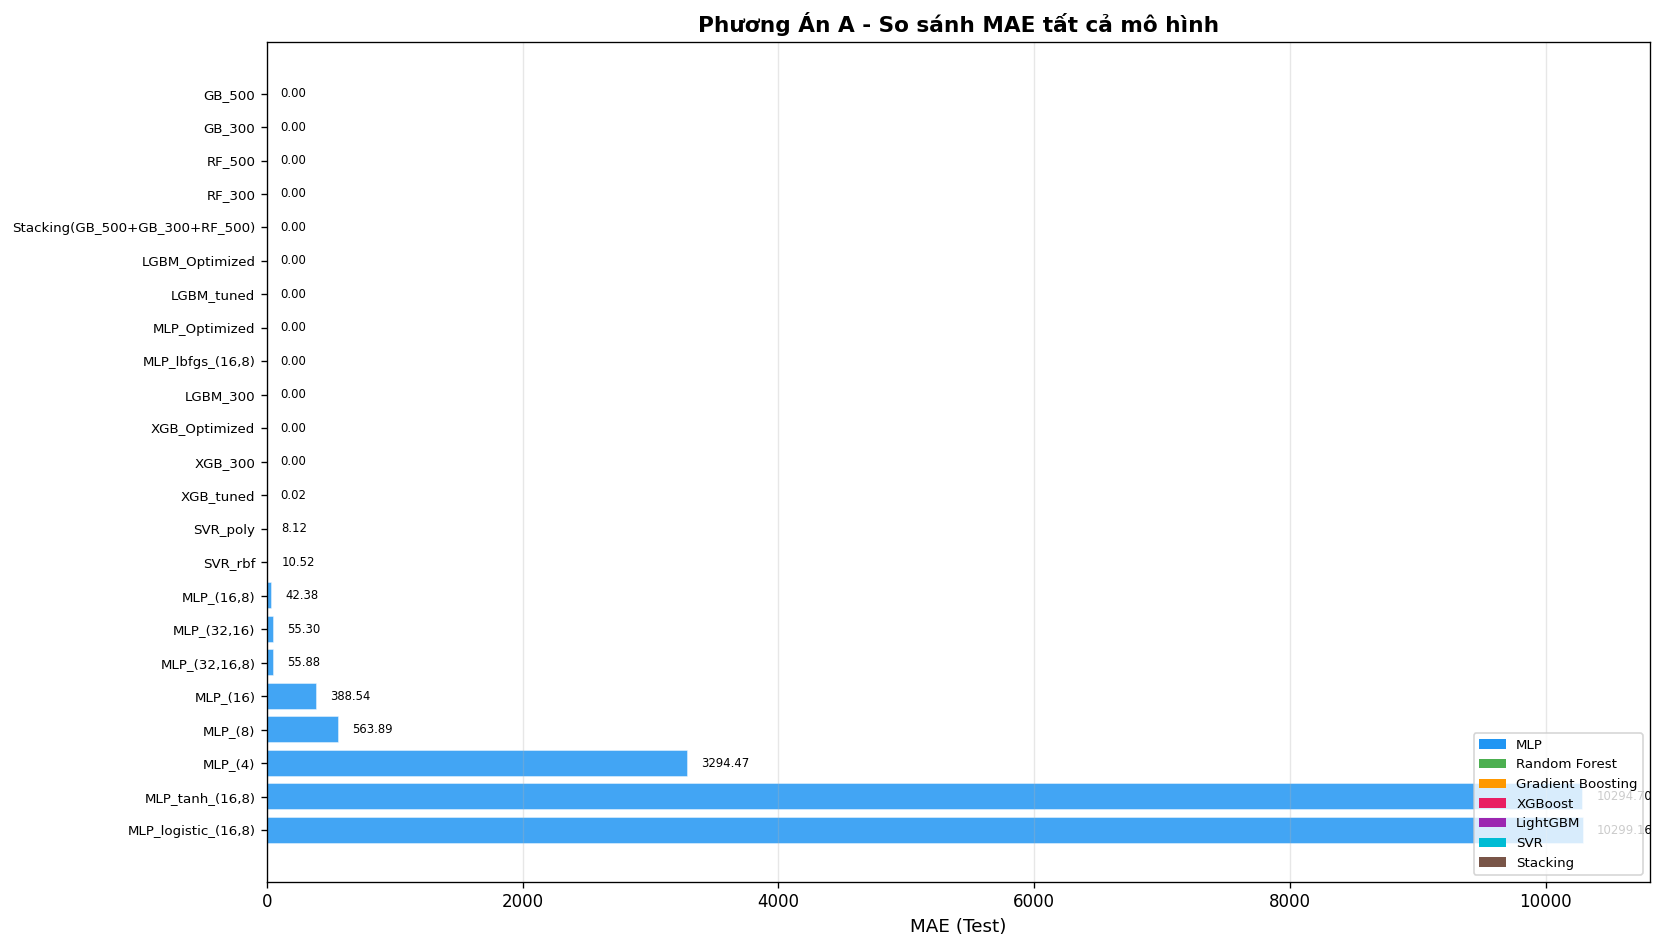

In [24]:
fig, ax = plt.subplots(figsize=(14, 8))
df_plot = df_final.sort_values('MAE (Test)')
colors = ['#2196F3' if 'MLP' in n else '#4CAF50' if 'RF' in n else '#FF9800' if 'GB' in n
          else '#E91E63' if 'XGB' in n else '#9C27B0' if 'LGBM' in n
          else '#00BCD4' if 'SVR' in n else '#795548' for n in df_plot['Mo hinh']]

bars = ax.barh(range(len(df_plot)), df_plot['MAE (Test)'], color=colors, alpha=0.85, edgecolor='white')
ax.set_yticks(range(len(df_plot)))
ax.set_yticklabels(df_plot['Mo hinh'], fontsize=8)
ax.set_xlabel('MAE (Test)', fontsize=11)
ax.set_title('Phương Án A - So sánh MAE tất cả mô hình', fontsize=13, fontweight='bold')
ax.invert_yaxis()
for i, v in enumerate(df_plot['MAE (Test)']):
    ax.text(v + max(df_plot['MAE (Test)'])*0.01, i, f'{v:.2f}', va='center', fontsize=7)
ax.grid(True, alpha=0.3, axis='x')

from matplotlib.patches import Patch
legend = [Patch(facecolor='#2196F3', label='MLP'), Patch(facecolor='#4CAF50', label='Random Forest'),
          Patch(facecolor='#FF9800', label='Gradient Boosting'), Patch(facecolor='#E91E63', label='XGBoost'),
          Patch(facecolor='#9C27B0', label='LightGBM'), Patch(facecolor='#00BCD4', label='SVR'),
          Patch(facecolor='#795548', label='Stacking')]
ax.legend(handles=legend, loc='lower right', fontsize=8)

plt.tight_layout()
plt.savefig('04_mae_comparison_all.png', dpi=150, bbox_inches='tight')
plt.show()

### 14.2 Actual vs Predicted - Mô hình tốt nhất

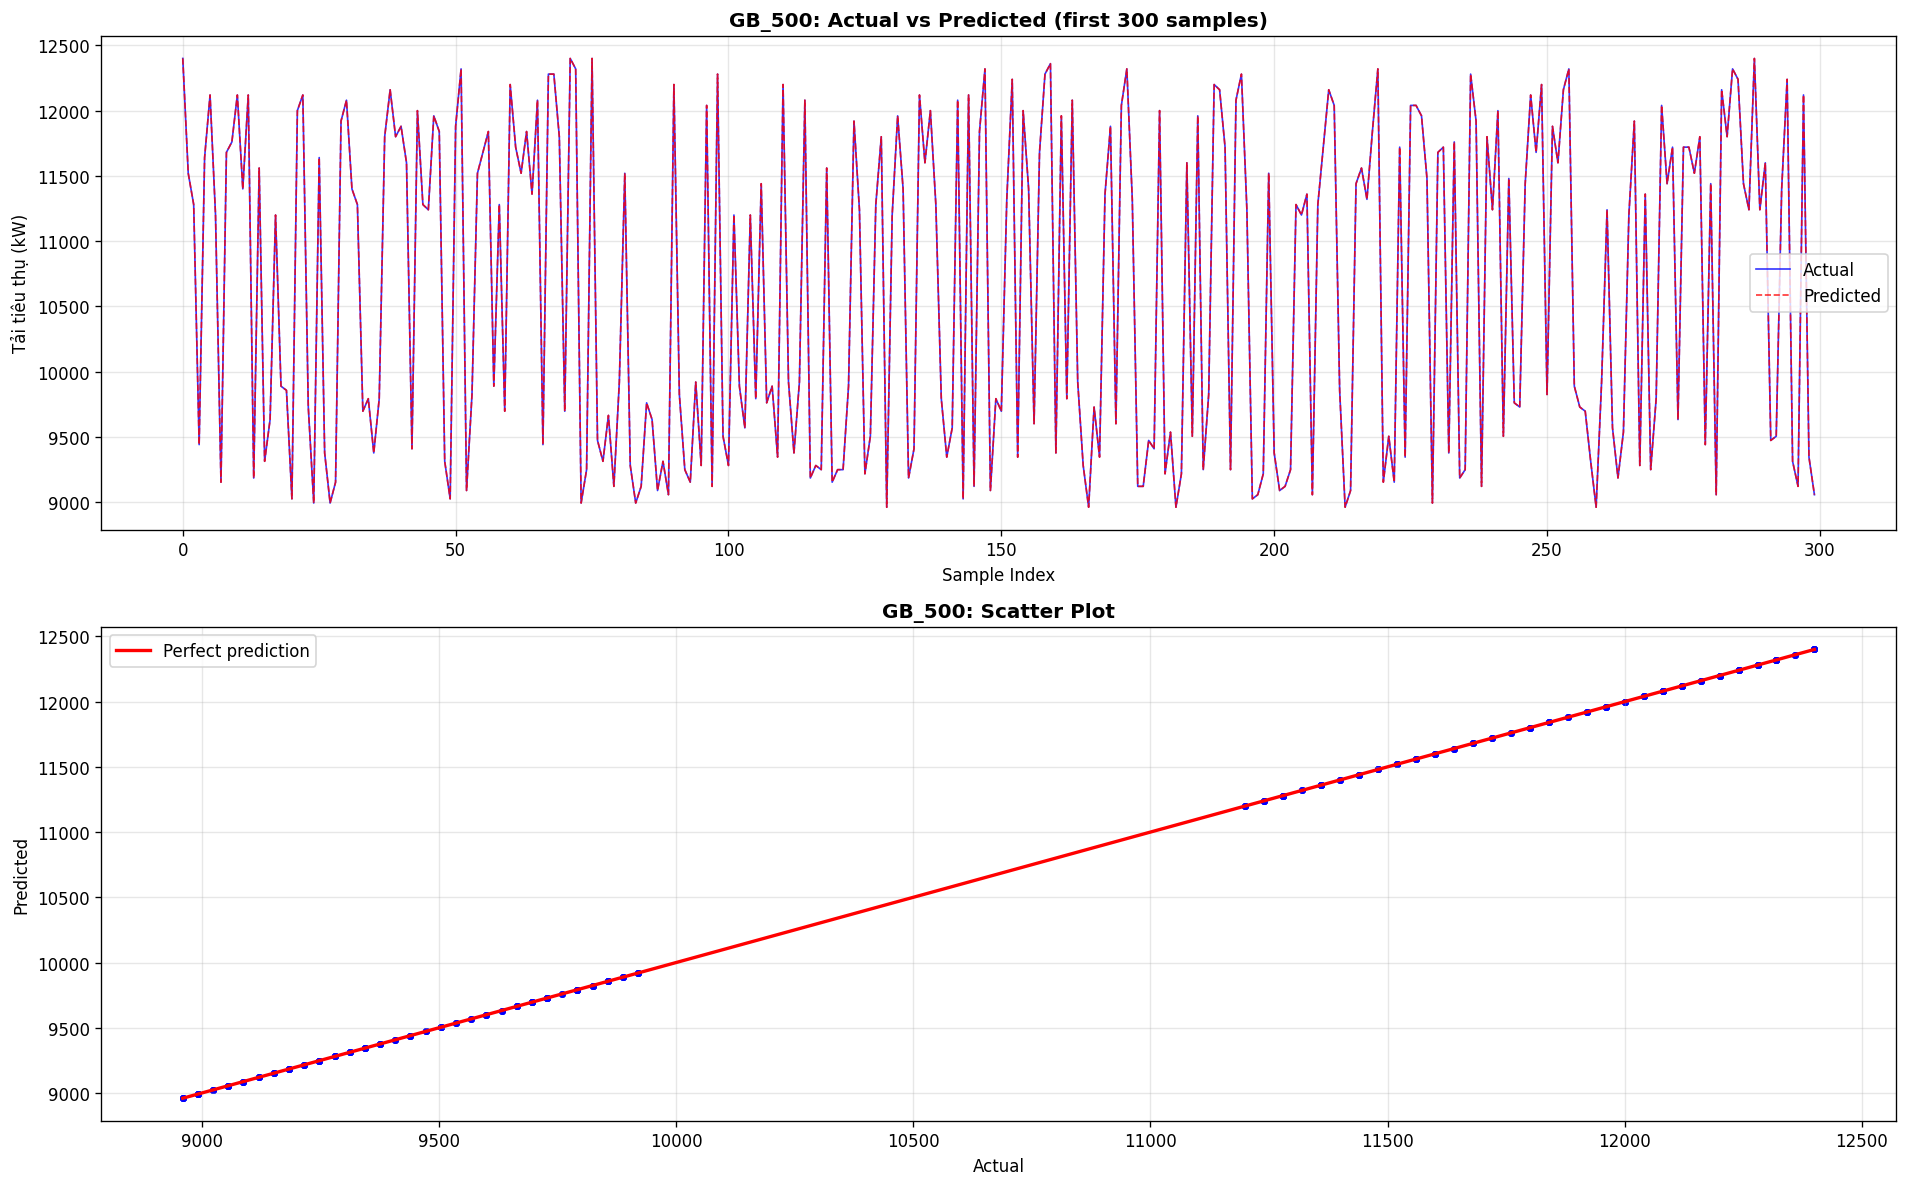

In [25]:
best_name = winner['Mo hinh']
p = predictions[best_name]

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Line plot
n_show = min(300, len(p['y_test']))
axes[0].plot(range(n_show), p['y_test'][:n_show], 'b-', label='Actual', alpha=0.8, linewidth=1)
axes[0].plot(range(n_show), p['y_pred_test'][:n_show], 'r--', label='Predicted', alpha=0.8, linewidth=1)
axes[0].set_xlabel('Sample Index')
axes[0].set_ylabel('Tải tiêu thụ (kW)')
axes[0].set_title(f'{best_name}: Actual vs Predicted (first {n_show} samples)', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Scatter plot
axes[1].scatter(p['y_test'], p['y_pred_test'], alpha=0.3, s=10, c='blue')
mn = min(p['y_test'].min(), p['y_pred_test'].min())
mx = max(p['y_test'].max(), p['y_pred_test'].max())
axes[1].plot([mn, mx], [mn, mx], 'r-', linewidth=2, label='Perfect prediction')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')
axes[1].set_title(f'{best_name}: Scatter Plot', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('05_best_actual_vs_predicted.png', dpi=150, bbox_inches='tight')
plt.show()

### 14.3 Residual Distribution & APE

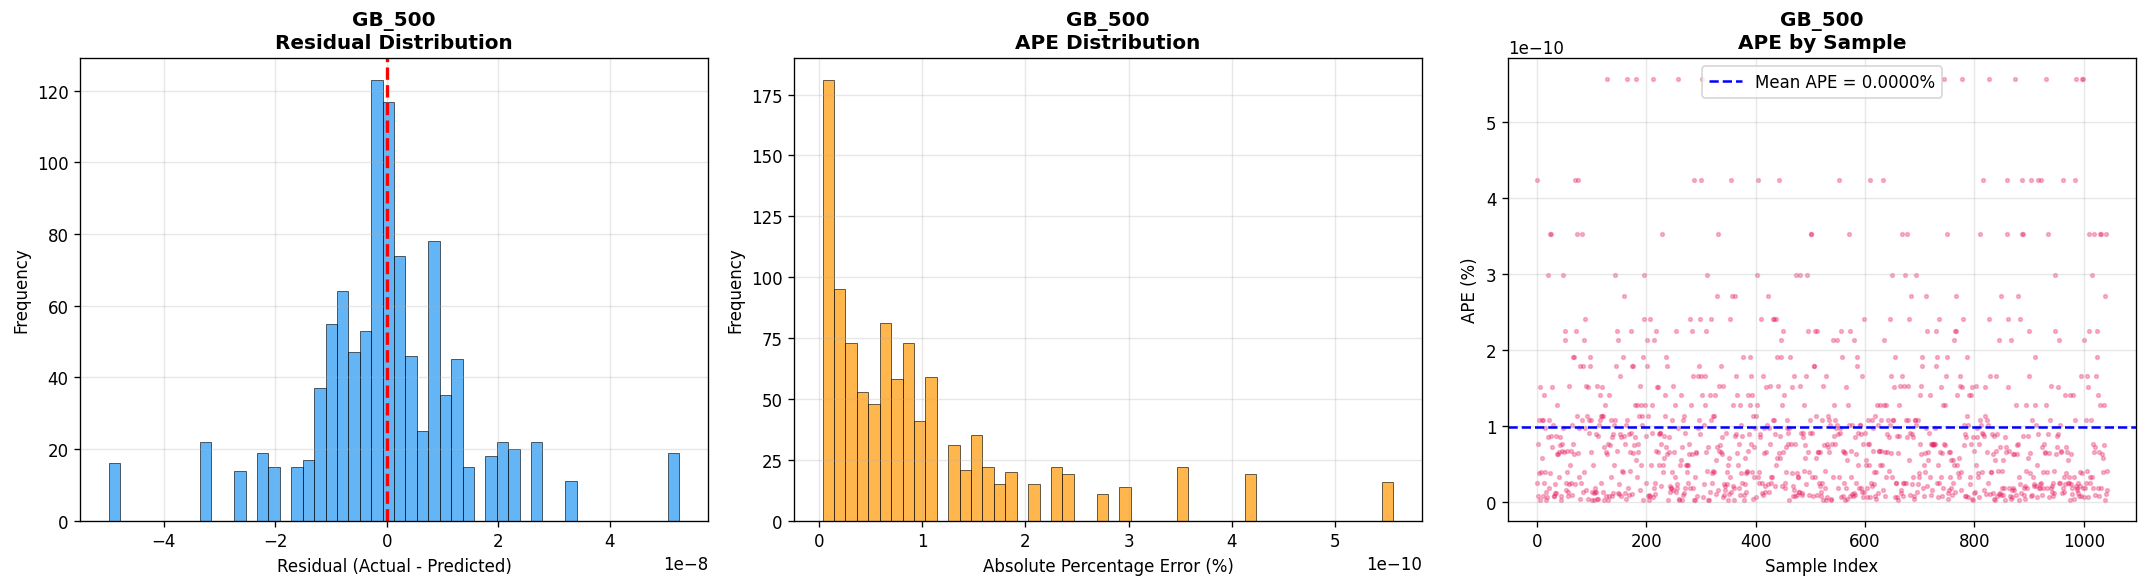

Residual Statistics:
  Mean = 0.0000
  Std  = 0.0000
  Min  = -0.0000
  Max  = 0.0000

APE Statistics:
  Mean = 0.0000%
  P50  = 0.0000%
  P90  = 0.0000%
  P99  = 0.0000%
  Max  = 0.0000%


In [26]:
residuals = p['y_test'] - p['y_pred_test']
ape = np.abs(residuals) / p['y_test'] * 100

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Residual distribution
axes[0].hist(residuals, bins=50, color='#2196F3', alpha=0.7, edgecolor='black', linewidth=0.5)
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Residual (Actual - Predicted)')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'{best_name}\nResidual Distribution', fontweight='bold')
axes[0].grid(True, alpha=0.3)

# APE distribution
axes[1].hist(ape, bins=50, color='#FF9800', alpha=0.7, edgecolor='black', linewidth=0.5)
axes[1].set_xlabel('Absolute Percentage Error (%)')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'{best_name}\nAPE Distribution', fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Error over samples
axes[2].scatter(range(len(ape)), ape, alpha=0.3, s=5, c='#E91E63')
axes[2].axhline(y=ape.mean(), color='blue', linestyle='--', label=f'Mean APE = {ape.mean():.4f}%')
axes[2].set_xlabel('Sample Index')
axes[2].set_ylabel('APE (%)')
axes[2].set_title(f'{best_name}\nAPE by Sample', fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('06_residual_ape.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Residual Statistics:")
print(f"  Mean = {residuals.mean():.4f}")
print(f"  Std  = {residuals.std():.4f}")
print(f"  Min  = {residuals.min():.4f}")
print(f"  Max  = {residuals.max():.4f}")
print(f"\nAPE Statistics:")
print(f"  Mean = {ape.mean():.4f}%")
print(f"  P50  = {np.percentile(ape, 50):.4f}%")
print(f"  P90  = {np.percentile(ape, 90):.4f}%")
print(f"  P99  = {np.percentile(ape, 99):.4f}%")
print(f"  Max  = {ape.max():.4f}%")

### 14.4 Biểu đồ huấn luyện (MAE comparison theo epoch - cho MLP models)

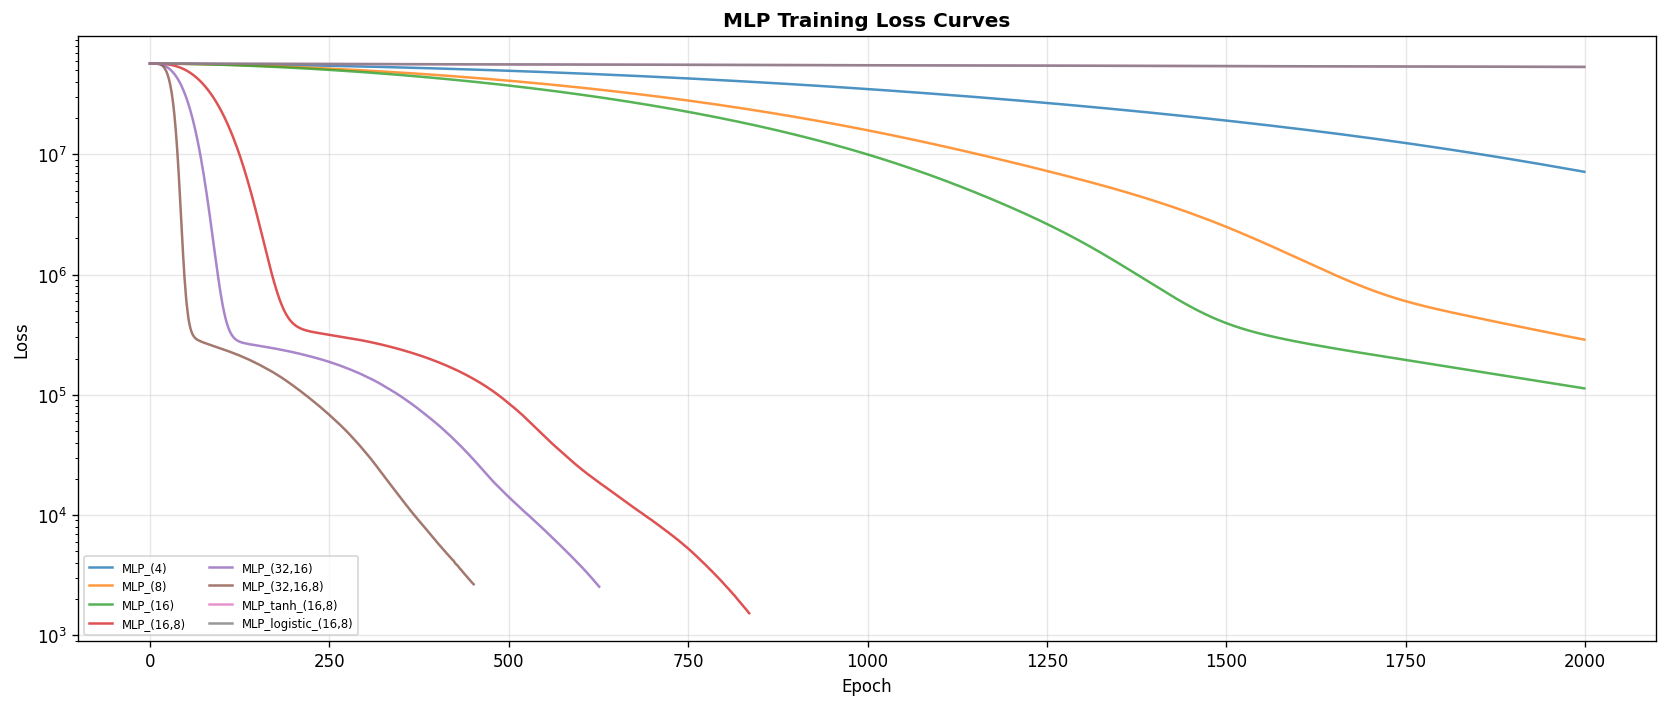

In [27]:
# Vẽ loss curve cho các MLP models
mlp_models_with_loss = {k: v for k, v in predictions.items()
                         if hasattr(v['model'], 'loss_curve_') and v['model'].loss_curve_}

if mlp_models_with_loss:
    fig, ax = plt.subplots(figsize=(14, 6))
    for name, data in mlp_models_with_loss.items():
        loss = data['model'].loss_curve_
        ax.plot(loss, label=name, alpha=0.8)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('MLP Training Loss Curves', fontweight='bold')
    ax.legend(fontsize=7, ncol=2)
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')
    plt.tight_layout()
    plt.savefig('07_mlp_loss_curves.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("Không có MLP model nào có loss_curve_ (có thể do dùng solver='lbfgs')")

## 15. XUẤT KẾT QUẢ RA EXCEL

In [28]:
output_path = 'ket_qua_phuong_an_A.xlsx'

with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
    # Sheet 1: Bảng xếp hạng tổng hợp
    df_final.to_excel(writer, sheet_name='Xep hang tong hop')

    # Sheet 2: Dự đoán - Best Model
    best_name = winner['Mo hinh']
    p = predictions[best_name]
    df_pred = pd.DataFrame({
        'Thuc te (Actual)': p['y_test'],
        'Du doan (Predicted)': np.round(p['y_pred_test'], 2),
        'Sai so tuyet doi': np.round(np.abs(p['y_test'] - p['y_pred_test']), 2),
        'Sai so tuong doi (%)': np.round(
            np.abs(p['y_test'] - p['y_pred_test']) / p['y_test'] * 100, 4),
    })
    df_pred.to_excel(writer, sheet_name='Du doan - Best Model', index=False)

    # Sheet 3: Chỉ số sai số - Best Model
    metrics_best = calc_metrics(p['y_test'], p['y_pred_test'])
    metrics_best['MAE_CV_mean'] = winner['MAE_CV_mean']
    metrics_best['MAE_CV_std'] = winner['MAE_CV_std']
    metrics_best['MAPE_CV_mean'] = winner['MAPE_CV_mean']
    metrics_best['MAPE_CV_std'] = winner['MAPE_CV_std']
    df_metrics = pd.DataFrame([{'Chi so': k, 'Gia tri': v} for k, v in metrics_best.items()])
    df_metrics.to_excel(writer, sheet_name='Chi so sai so', index=False)

    # Sheet 4: So sánh với L2N19 gốc
    comparison = pd.DataFrame({
        'Chi so': ['MAE', 'RMSE', 'MAPE (%)', 'nRMSE', 'Model Name'],
        'L2N19 goc': [19.57, 20.63, 0.180, 0.006, 'L2N19 (8-4-1)'],
        'Best Model moi': [
            winner['MAE (Test)'], winner['RMSE (Test)'],
            winner['MAPE % (Test)'], winner['nRMSE (Test)'],
            winner['Mo hinh']
        ],
    })
    comparison.to_excel(writer, sheet_name='So sanh voi L2N19', index=False)

    # Sheet 5: Hyperparameter tuning results
    if 'search_mlp' in dir():
        hp_data = []
        if 'search_mlp' in dir():
            hp_data.append({'Model': 'MLP_Optimized', 'Best_MAE_CV': round(-search_mlp.best_score_, 4),
                           'Best_Params': str(search_mlp.best_params_)})
        if 'search_xgb' in dir():
            hp_data.append({'Model': 'XGB_Optimized', 'Best_MAE_CV': round(-search_xgb.best_score_, 4),
                           'Best_Params': str(search_xgb.best_params_)})
        if 'search_lgbm' in dir():
            hp_data.append({'Model': 'LGBM_Optimized', 'Best_MAE_CV': round(-search_lgbm.best_score_, 4),
                           'Best_Params': str(search_lgbm.best_params_)})
        pd.DataFrame(hp_data).to_excel(writer, sheet_name='Hyperparameter Tuning', index=False)

print(f"✓ Đã xuất kết quả: {output_path}")
print(f"  Sheets: Xep hang tong hop, Du doan, Chi so sai so, So sanh, HP Tuning")

✓ Đã xuất kết quả: ket_qua_phuong_an_A.xlsx
  Sheets: Xep hang tong hop, Du doan, Chi so sai so, So sanh, HP Tuning


## 16. TÓM TẮT & KẾT LUẬN

In [29]:
print("═" * 60)
print("  KẾT LUẬN - PHƯƠNG ÁN A (5 FEATURES)")
print("═" * 60)
print(f"\n  Tổng mô hình đã thử: {len(df_final)}")
print(f"  Features: {features_A}")
print(f"  Samples: {len(y)} (Train: {len(y_train)}, Test: {len(y_test)})")
print(f"\n  TOP 5 MÔ HÌNH:")
print(f"  {'-'*56}")
for i, (_, row) in enumerate(df_final.head(5).iterrows()):
    print(f"  #{i+1} {row['Mo hinh']:<30} MAE={row['MAE (Test)']:.4f} | MAPE={row['MAPE % (Test)']:.4f}%")

print(f"\n  ★ CHIẾN THẮNG: {winner['Mo hinh']}")
print(f"    MAE  = {winner['MAE (Test)']:.4f}")
print(f"    MAPE = {winner['MAPE % (Test)']:.4f}%")
print(f"    R²   = {winner['R2 (Test)']:.6f}")
print(f"\n  File kết quả: {output_path}")
print(f"  Hình ảnh: 01-07_*.png")
print("═" * 60)

════════════════════════════════════════════════════════════
  KẾT LUẬN - PHƯƠNG ÁN A (5 FEATURES)
════════════════════════════════════════════════════════════

  Tổng mô hình đã thử: 23
  Features: ['độ ẩm', 'nhiệt độ', 'góc nghiêng', 'ca', 'công suất tb']
  Samples: 5220 (Train: 4176, Test: 1044)

  TOP 5 MÔ HÌNH:
  --------------------------------------------------------
  #1 GB_500                         MAE=0.0000 | MAPE=0.0000%
  #2 GB_300                         MAE=0.0000 | MAPE=0.0000%
  #3 RF_500                         MAE=0.0000 | MAPE=0.0000%
  #4 RF_300                         MAE=0.0000 | MAPE=0.0000%
  #5 Stacking(GB_500+GB_300+RF_500) MAE=0.0000 | MAPE=0.0000%

  ★ CHIẾN THẮNG: GB_500
    MAE  = 0.0000
    MAPE = 0.0000%
    R²   = 1.000000

  File kết quả: ket_qua_phuong_an_A.xlsx
  Hình ảnh: 01-07_*.png
════════════════════════════════════════════════════════════
